### Import the Libraries

In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

### HOG Feature Extraction

In [2]:
def get_img(image_directory, rotated= False):
    image = Image.open(image_directory)
    image = image.convert('L')

    if rotated == True:
        image = image.rotate(90)

    return image
    
def get_feature_vector(image, grid_q= 4, no_orientation= 8):
    if type(grid_q)== np.ndarray: # ndarray path
        hog_features= []
        for gq in grid_q:
            hf= get_feature_vector(image, grid_q= gq, no_orientation= no_orientation)
            hog_features= np.append(hog_features, hf)
    else: # integer path
        ppc= (int(image.size[0]/grid_q), int(image.size[1]/grid_q))
        hog_features= hog(image, orientations= no_orientation, pixels_per_cell= (int(image.size[0]/grid_q), int(image.size[1]/grid_q)),
                        cells_per_block=(1, 1), feature_vector= True)

    return hog_features

# GRIDQ= 4
GRIDQ= np.arange(1, 6)
ORIENTATION= 8

### Data Acquisition

In [3]:
def get_data(file_dir, csv_dir, i_start=1, augment=False):
    bio_csv= np.loadtxt(csv_dir)

    feature_matrix= []
    img_directories= []
    labels= []

    for index, label in enumerate(bio_csv):
        if not np.isnan(label):
            img_dir = file_dir + str(index + i_start) + ".png"
            img = get_img(img_dir)

            feature_vec = get_feature_vector(img, grid_q=GRIDQ, no_orientation=ORIENTATION)
            
            img_directories.append(img_dir)
            feature_matrix.append(feature_vec)
            labels.append(label)

            if augment:
                # Rotations
                for i in range(1, 4):
                    a_img = img.rotate(90*i)
                    a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
                    a_label = (label+90*i)%180
                    img_directories.append(img_dir)
                    feature_matrix.append(a_feature_vec)
                    labels.append(a_label)
                # Flips
                a_img = ImageOps.mirror(img)
                a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
                a_label = (180-label)%180
                img_directories.append(img_dir)
                feature_matrix.append(a_feature_vec)
                labels.append(a_label)
                
                a_img = ImageOps.flip(img)
                a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
                a_label = (180-label)%180
                img_directories.append(img_dir)
                feature_matrix.append(a_feature_vec)
                labels.append(a_label)
                
                a_img = ImageOps.mirror(ImageOps.flip(img))
                a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
                a_label = label
                img_directories.append(img_dir)
                feature_matrix.append(a_feature_vec)
                labels.append(a_label)


    feature_matrix= np.array(feature_matrix)
    labels= np.array(labels)
    img_directories= np.array(img_directories)
    return feature_matrix, labels, img_directories


In [4]:
file_dir= "images/bio/"
csv_dir= "images/bio/labels.csv"

bio_feature_matrix, bio_labels, bio_img_directories= get_data(file_dir, csv_dir)

print(f"Total picture/label count: {bio_img_directories.size}/{bio_labels.size}")
print(f"Total feature count: {bio_feature_matrix.shape[1]}")

zero_ratio= 1 - np.count_nonzero(bio_feature_matrix)/bio_feature_matrix.size 
print(f"Zero feature ratio: {100*zero_ratio:.1f}%")

unique_feature, c_unique_feature= np.unique(bio_feature_matrix, return_counts= True)
unique_ratio= 1 - np.sum(np.sort(c_unique_feature[c_unique_feature!= 1]))/bio_feature_matrix.size 
print(f"Unique feature ratio: {100*unique_ratio:.1f}%")

Total picture/label count: 673/673
Total feature count: 440
Zero feature ratio: 1.3%
Unique feature ratio: 55.7%


(array([ 74., 277., 367., 424., 497., 351., 182.,  89.,  46.,  66., 200.,
        297., 402., 493., 363., 275., 221.,  87.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180.]),
 <BarContainer object of 18 artists>)

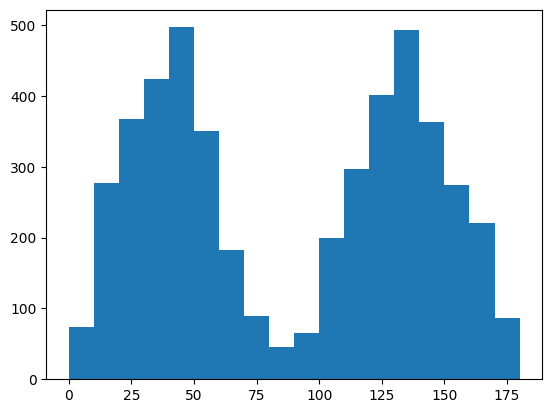

In [5]:
bio_feature_matrix, bio_labels, bio_img_directories= get_data(file_dir, csv_dir, augment=True)

plt.hist(bio_labels, bins=18)

Total sampled picture/label count: 1065/1065


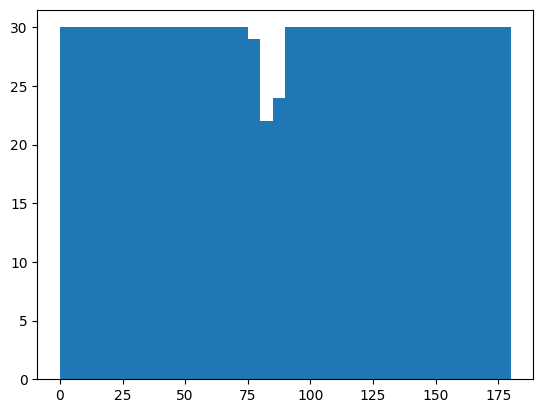

In [18]:
# Create a mask to filter the data
mask = np.zeros(bio_labels.shape, dtype=bool)

angle_range = 5
for angle in range(0, 181, angle_range):
    indices = np.where((bio_labels >= angle) & (bio_labels < angle + angle_range))[0]
    np.random.shuffle(indices)
    mask[indices[:30]] = True

# Apply the mask to the feature matrix, labels, and image directories
sampled_feature_matrix = bio_feature_matrix[mask]
sampled_labels = bio_labels[mask]
sampled_img_directories = bio_img_directories[mask]

print(f"Total sampled picture/label count: {sampled_img_directories.size}/{sampled_labels.size}")
plt.hist(sampled_labels, bins=180//angle_range);

### Scaler & PCA & Support Vector Regressor & Hyperparameter Tuning

Initial features: 440 Final components: 2
Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


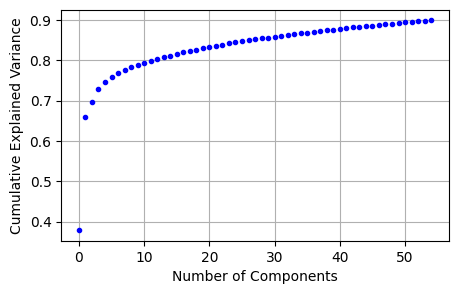

In [29]:
X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(bio_feature_matrix, bio_labels, np.arange(bio_labels.size), test_size= .3, random_state= 0)
X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(sampled_feature_matrix, sampled_labels, np.arange(sampled_labels.size), test_size= .3, random_state= 0)

# Scaler
scaler= StandardScaler()

# PCA
pca= PCA()
principal_components= pca.fit_transform(X_train)
var_csum= np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(5,3))
plt.plot(var_csum[var_csum < .9], "b .")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

required_variance= .6
no_components= sum(pca.explained_variance_ratio_.cumsum() < required_variance) + 1
pca_var= PCA(no_components)

# bio_feature_matrix= bio_feature_matrix[bio_labels!= 0]
print(f"Initial features: {bio_feature_matrix.shape[1]} Final components: {no_components}")

# SVR
svr= SVR()

# Hyperparameter tuning
param_grid= [
  {"kernel": ["linear"], "C": [.1, 1, 10, 100]},
  {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, .1, .01, .001, 0.0001]}
 ]

param_grid= [
  {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
 ]

svr_tuned= GridSearchCV(svr, param_grid= param_grid, verbose= True)
svr_tuned.fit(X_train, y_train)

print(svr_tuned.best_params_)
# print(svr_tuned.cv_results_)

# Model pipeline
model= Pipeline([
    ("Scaler", scaler),
    ("PCA", pca_var),
    ("SVR", svr_tuned.best_estimator_)
])

### Train and Evlauate

In [30]:
model.fit(X_train, y_train)
y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error: 16.200
R^2 Score: 0.625


### Visualize Angle Distribution and Deviation

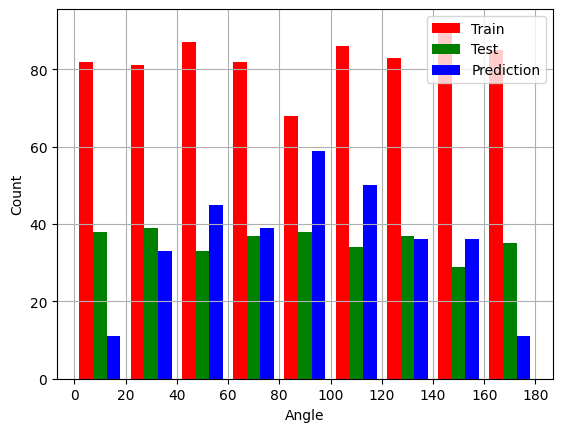

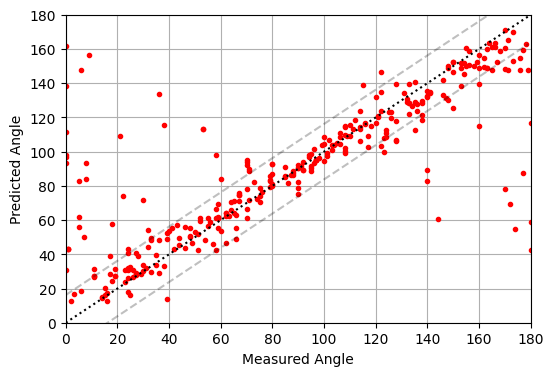

In [31]:
plt.figure()
plt.hist([y_train, y_test, y_pred], color= ["r", "g", "b"], bins= np.arange(0, 181, 20))

plt.xticks(np.arange(0, 181, 20))
plt.ylabel("Count")
plt.xlabel("Angle")
plt.legend(["Train", "Test", "Prediction"])
plt.grid()

plt.figure(figsize= (6, 4))
plt.plot(y_test, y_pred, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.plot(np.arange(0, 180), np.arange(0, 180)-mae, "k--", alpha= .25)
plt.plot(np.arange(0, 180), np.arange(0, 180)+mae, "k--", alpha= .25)
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])
plt.grid()


### Max and Min Error Pictures

Text(0.5, 0.98, 'Min Errors')

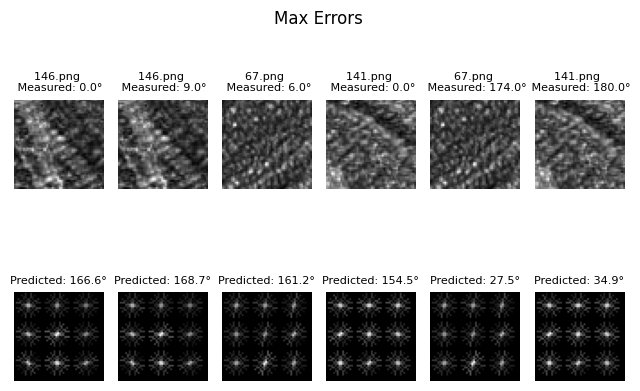

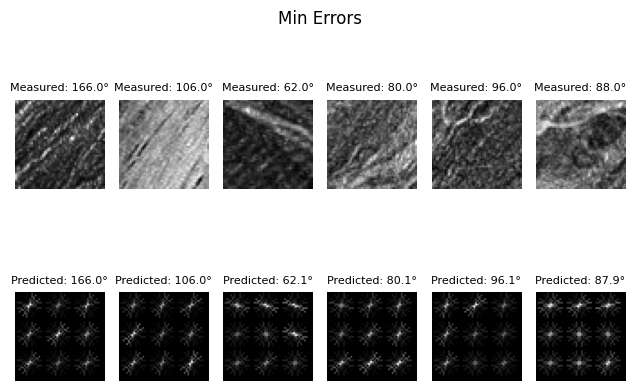

In [28]:
y_error= abs(y_pred-y_test)
# Max Errors
y_error_sorted= np.sort(y_error)[::-1]
no_pics= 6

fig, axs = plt.subplots(2, no_pics)

for i in np.arange(0, no_pics):
    i_max_error= np.where(y_error== y_error_sorted[i])[0]
    i_abs= i_test[i_max_error][0]

    # print(f"Max error at i_abs= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[i]:.2f}")

    img_dir= bio_img_directories[i_abs]
    img= get_img(img_dir)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.size[0]/3), int(img.size[1]/3)),
                        visualize=True, feature_vector= True)


    plt.subplot(2, no_pics, i+1)
    plt.imshow(img, cmap= "gray")
    #plt.title("Original Image")
    plt.axis("off")
    plt.title(f"{img_dir[11:]} \n Measured: {y_test[i_max_error][0]}{chr(176)}", size= 8)

    plt.subplot(2, no_pics, i+1 + no_pics)
    plt.imshow(hog_image, cmap='gray')
    #plt.title("HOG Image")
    plt.axis("off")
    plt.title(f"Predicted: {y_pred[i_max_error][0]:.1f}{chr(176)}", size= 8)

plt.tight_layout()
plt.suptitle("Max Errors")

# Min Errors
y_error_sorted= np.sort(y_error)
no_pics= 6

fig, axs = plt.subplots(2, no_pics)

for i in np.arange(0, no_pics):
    i_max_error= np.where(y_error== y_error_sorted[i])[0]
    i_abs= i_test[i_max_error][0]

    # print(f"Max error at i_abs= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[i]:.2f}")

    img_dir= bio_img_directories[i_abs]
    img= get_img(img_dir)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.size[0]/3), int(img.size[1]/3)),
                        visualize=True, feature_vector= True)


    plt.subplot(2, no_pics, i+1)
    plt.imshow(img, cmap= "gray")
    plt.axis("off")
    plt.title(f"Measured: {y_test[i_max_error][0]}{chr(176)}", size= 8)

    plt.subplot(2, no_pics, i+1 + no_pics)
    plt.imshow(hog_image, cmap='gray')
    plt.axis("off")
    plt.title(f"Predicted: {y_pred[i_max_error][0]:.1f}{chr(176)}", size= 8)

plt.tight_layout()
plt.suptitle("Min Errors")

### Por Images

In [23]:
por_feature_matrix= []
por_img_directories= []

for img_dir in os.listdir("images/por_image/"):
    if img_dir.endswith(".png"):
        img_dir= "images/por_image/" + img_dir
        img= get_img(img_dir)
        
        feature_vec= get_feature_vector(img, grid_q=GRIDQ, no_orientation=ORIENTATION)
        por_feature_matrix.append(feature_vec)
        por_img_directories.append(img_dir)
        print(len(feature_vec))

por_feature_matrix= np.array(por_feature_matrix)
por_prediction= model.predict(por_feature_matrix)

fig, axs= plt.subplots(1, len(por_img_directories), figsize= (16, 8))
for i, img_dir in enumerate(por_img_directories):
    img= get_img(img_dir)
    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.size[0]/4), int(img.size[1]/4)),
                        visualize=True, feature_vector= True)

    plt.subplot(1, len(por_img_directories), i+1)
    plt.imshow(img, cmap= "gray")
    plt.axis("off")
    plt.title(f"Predicted: {por_prediction[i]:.2f}{chr(176)}", size= 8)


320
440
440
440
320
320
320
320
320
320


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

### Diffusion Data

Mean Absolute Error: 11.132


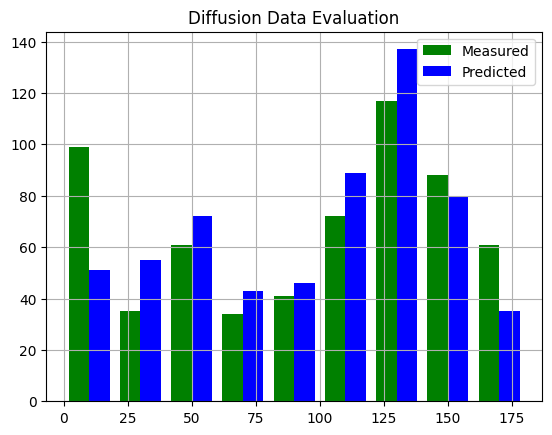

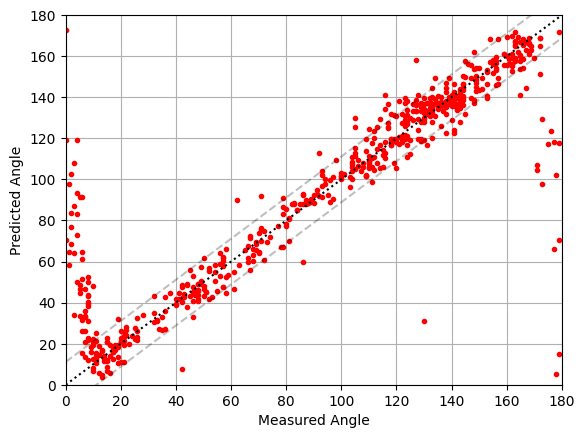

In [26]:
file_dir= "images/diffusion/diffusion_voxels/"
csv_dir= "images/diffusion/diffusion_voxels/diffusion.csv"

diffusion_feature_matrix, diffusion_labels, diffusion_img_directories= get_data(file_dir, csv_dir, 2001)

diffusion_prediction= model.predict(diffusion_feature_matrix)
mae= mean_absolute_error(diffusion_labels, diffusion_prediction)

print(f"Mean Absolute Error: {mae:.3f}")

plt.hist([diffusion_labels, diffusion_prediction], color= ["g", "b"], bins= np.arange(0, 181, 20))
plt.legend(["Measured", "Predicted"])
plt.title("Diffusion Data Evaluation")
plt.grid()

plt.figure()
plt.plot(diffusion_labels, diffusion_prediction, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.plot(np.arange(0, 180), np.arange(0, 180)-mae, "k--", alpha= .25)
plt.plot(np.arange(0, 180), np.arange(0, 180)+mae, "k--", alpha= .25)
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])
plt.grid()


### Model Pickle 

In [ ]:
def build_model(X_train, y_train):
    scaler= StandardScaler()
    pca_var= PCA(2)

    svr= SVR()

    param_grid= [
    {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
    ]

    svr_tuned= GridSearchCV(svr, param_grid= param_grid)
    svr_tuned.fit(X_train, y_train)

    model= Pipeline([
        ("Scaler", scaler),
        ("PCA", pca_var),
        ("SVR", svr_tuned.best_estimator_)
    ])
    return model

In [ ]:
print(f"Biological picture/label count: {bio_img_directories.size}/{bio_labels.size}")
print(f"Diffusion picture/label count: {diffusion_img_directories.size}/{diffusion_labels.size}")
print(f"Feature count: {diffusion_feature_matrix.shape[1]}")

combined_feature_matrix= np.append(bio_feature_matrix, diffusion_feature_matrix, axis= 0)
combined_labels= np.append(bio_labels, diffusion_labels)

EPOCH= 5
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(combined_feature_matrix, combined_labels, np.arange(combined_labels.size), test_size= .3)
  model= build_model(X_train, y_train)

  model.fit(X_train, y_train)
  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/combined_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
plt.figure()
plt.hist([diffusion_labels, bio_labels], bins= np.arange(0, 181, 20))

plt.xticks(np.arange(0, 181, 20))
plt.ylabel("Count")
plt.xlabel("Angle")
plt.legend(["Diffusion", "Biological"])
plt.grid()
